<hr>

# <a id='iasi_co'></a>Metop-B IASI - Total Column Carbon Monoxide - Level 2

The [Infrared Atmospheric Sounding Interferometer (IASI)](https://www.eumetsat.int/website/home/Satellites/CurrentSatellites/Metop/MetopDesign/IASI/index.html) is an instrument onboard the Metop-A/B/C satellites. It provides information on the vertical structure of temperature and humidity as well as main atmospheric species.

This notebook provides you an introduction to data from Metop-B IASI, featuring the fires in Indonesia in 2019. IASI Level 2 data can be downloaded from the [IASI portal](https://iasi.aeris-data.fr/). The data product is carbon monoxide, which is also found in smoke from fires.

<hr>

### Load required libraries

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import ipynb
from skimage import exposure
import os

from netCDF4 import Dataset
import pandas as pd

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.cm as cm

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

### Load netCDF data with `xarray`

IASI Level 2 data from the [IASI portal](https://iasi.aeris-data.fr/) are disseminated in the `netCDF` format. You can use the Python library [xarray](http://xarray.pydata.org/en/stable/index.html) to access and manipulate datasets in `netCDF` format.

Xarray's function `xr.open_dataset` enables you to open a `netCDF` file. Once loaded, you can inspect the data structure.

You see, that the data is a 3-dimensional vector with more than 550,000 individual entries for the `time` dimension. `latitude`, `longitude` and other parameters are stored as individual data variables.

In [3]:
iasi_file = xr.open_dataset('../eodata/iasi/nc/co/2019/09/05/IASI_METOPB_L2_CO_20190905_ULB-LATMOS_V6.4.0.nc')

iasi_file

<xarray.Dataset>
Dimensions:                            (time: 556616, nlayers: 19, npressures: 20)
Coordinates:
  * time                               (time) float64 4e+08 4e+08 ... 4.001e+08
Dimensions without coordinates: nlayers, npressures
Data variables: (12/21)
    time_string                        (time) |S16 ...
    time_in_day                        (time) float64 ...
    latitude                           (time) float32 ...
    longitude                          (time) float32 ...
    solar_zenith_angle                 (time) float32 ...
    satellite_zenith_angle             (time) float32 ...
    ...                                 ...
    CO_total_column                    (time) float32 ...
    CO_total_column_error              (time) float32 ...
    CO_degrees_of_freedom              (time) float32 ...
    air_partial_column_profile         (time, nlayers) float32 ...
    atmosphere_pressure_grid           (time, npressures) float32 ...
    averaging_kernel_matrix            (time, nlayers, nlayers) float32 ...
Attributes: (12/31)
    title:                       IASI/METOPB ULB-LATMOS carbon monoxide (CO) ...
    institution:                 ULB-LATMOS for algorithm development ; EUMET...
    product_version:             6.4.0
    history:                     2020-06-30 13:09:59 (date of data extraction...
    summary:                     This dataset contains Level 2 carbon monoxid...
    source:                      EUMETSAT IASI Level 2 carbon monoxide (CO) d...
    ...                          ...
    sensor:                      IASI
    spatial_resolution:          12km at nadir
    creator_type:                institution
    creator_name:                ULB-LATMOS
    contact_email:               contact form at http://iasi.aeris-data.fr/co...
    data_policy:                 see https://iasi.aeris-data.fr/data-use-policy/

As a next step, you can select the variable `CO_total_column`, which holds data values for total column carbon monoxide.

In [4]:
co = iasi_file['CO_total_column']
co

<xarray.DataArray 'CO_total_column' (time: 556616)>
[556616 values with dtype=float32]
Coordinates:
  * time     (time) float64 4e+08 4e+08 4e+08 ... 4.001e+08 4.001e+08 4.001e+08
Attributes:
    units:                                                  mol m-2
    long_name:                                              retrieved carbon ...
    standard_name:                                          atmosphere_mole_c...
    ancillary_variables:                                    CO_total_column_e...
    multiplication_factor_to_convert_to_molecules_per_cm2:  6.02214086e+19

### Load data into a xarray.DataArray with the function `generate_xr_from_1D_vec`

With the help of the function [generate_xr_from_1D_vec](../functions.ipynb#generate_xr_from_1D_vec), you can generate a `xarray.DataArray` object, with `latitude` and `longitude` values as coordinates and the total column carbon monoxide information as data values. This data structure will be helpful for plotting and masking the data.

Further, you can retrieve the information for the variables `long_name`, `unit` and `variable name` from the attributes of the data object `co`.

In [5]:
iasi_co_da = generate_xr_from_1D_vec(file=iasi_file,
                                     lat_path='latitude', 
                                     lon_path='longitude',
                                     variable=co.data, 
                                     parameter_name=co.name, 
                                     longname=co.long_name, 
                                     no_of_dims=1, 
                                     unit=co.units)

iasi_co_da

<xarray.DataArray 'CO_total_column' (ground_pixel: 556616)>
array([0.03668438, 0.03141565, 0.02974151, ..., 0.03570849, 0.03658528,
       0.03504629], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 22.29 22.2 21.98 ... 79.18 80.92 81.36
    longitude  (ground_pixel) float32 -48.65 -49.01 -48.94 ... 166.6 153.7
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  retrieved carbon monoxide total column in mole/m2
    units:      mol m-2

### Load quality flag information

The IASI Level 2 data files provide you information on the quality for each data point. This information is useful to generate a quality mask and to mask out data points with a non sufficient quality.

In order to do so, you have to load the quality flag variable `retrieval_quality_flag` from the data file. The pixels with a `quality flag = 2` are the most reliable pixels. Pixels with a `quality flag = 1 or 0` shall be masked out.

In [6]:
qf = iasi_file['retrieval_quality_flag']
qf

<xarray.DataArray 'retrieval_quality_flag' (time: 556616)>
[556616 values with dtype=int32]
Coordinates:
  * time     (time) float64 4e+08 4e+08 4e+08 ... 4.001e+08 4.001e+08 4.001e+08
Attributes:
    long_name:  retrieval quality flag summarizing processing flags
    comment:    = 2 for the most reliable pixels; = 1 for the valuable pixels...

You can re-use the [generate_xr_from_1D_vec](../functions.ipynb#generate_xr_from_1D_vec) function again in order to generate a `xarray.DataArray` with the quality flag information.

In [7]:
iasi_co_qf_da = generate_xr_from_1D_vec(file=iasi_file,
                                        lat_path='latitude', 
                                        lon_path='longitude', 
                                        variable=qf, 
                                        parameter_name=qf.name, 
                                        longname=qf.long_name, 
                                        no_of_dims=1, 
                                        unit='-')
iasi_co_qf_da

<xarray.DataArray 'retrieval_quality_flag' (ground_pixel: 556616)>
array([1, 2, 2, ..., 1, 2, 1], dtype=int32)
Coordinates:
    latitude   (ground_pixel) float32 22.29 22.2 21.98 ... 79.18 80.92 81.36
    longitude  (ground_pixel) float32 -48.65 -49.01 -48.94 ... 166.6 153.7
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  retrieval quality flag summarizing processing flags
    units:      -

### Mask the Total Column Carbon Monoxide data

The quality flag information can now be used to mask the `xarray.DataArray` with the data values. You can make use of the function [generate_masked_array](../functions.ipynb#generate_masked_array), where you can specify which pixels shall remain and which ones shall be eliminated. All data points with a `quality flag = 2` shall be kept, all others shall be masked out.

You see that the number of data points reduced to just a bit less than 400,000 instead of more than 500,000.

In [8]:
iasi_co_masked = generate_masked_array(xarray=iasi_co_da,
                                       mask=iasi_co_qf_da,
                                       threshold=2,
                                       operator='=')
iasi_co_masked

<xarray.DataArray (ground_pixel: 400921)>
array([0.03141565, 0.02974151, 0.02990203, ..., 0.03567718, 0.03343812,
       0.03658528], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 22.2 21.98 22.32 ... 78.36 78.47 80.92
    longitude  (ground_pixel) float32 -49.01 -48.94 -47.72 ... -173.6 166.6
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  retrieved carbon monoxide total column in mole/m2
    units:      mol m-2

### Convert the Total Column Carbon Monoxide data from mol/m<sup>2</sup> to molecules/cm<sup>2</sup>

The last step before visualizing the total column carbon monoxide information is to convert the data from `mol/m2` to `molecules/cm2`. The loaded data variable `co` has an attribute called `multiplication_factor_to_convert_to_molecules_per_cm2`, which is used to convert the data values.

In [9]:
iasi_co_masked_converted = iasi_co_masked*co.multiplication_factor_to_convert_to_molecules_per_cm2
iasi_co_masked_converted 

<xarray.DataArray (ground_pixel: 400921)>
array([1.8918946e+18, 1.7910757e+18, 1.8007421e+18, ..., 2.1485302e+18,
       2.0136909e+18, 2.2032171e+18], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 22.2 21.98 22.32 ... 78.36 78.47 80.92
    longitude  (ground_pixel) float32 -49.01 -48.94 -47.72 ... -173.6 166.6
Dimensions without coordinates: ground_pixel

### Visualize the masked dataset with the function `visualize_scatter`

You can visualize the IASI Total Column Carbon Monoxide data with the function [visualize_scatter](../functions.ipynb#visualize_scatter), which uses matplotlib's `scatterplot` function. You can set an `Orthographic()` projection and focus on a region over California.

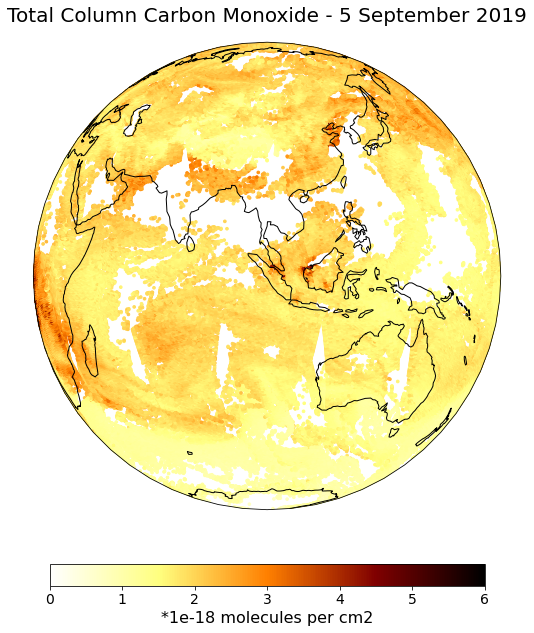

In [10]:
visualize_scatter(xr_dataarray=iasi_co_masked_converted, 
                  conversion_factor=1e-18,
                  projection=ccrs.Orthographic(100,0), 
                  vmin=0, 
                  vmax=6, 
                  point_size=7, 
                  color_scale='afmhot_r', 
                  unit='*1e-18 molecules per cm2', 
                  title='Total Column Carbon Monoxide - 5 September 2019')

<br>

<hr>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.